In [5]:
import numpy as np
"""from google.colab import drive
drive.mount('/content/drive')
!ls drive/'My Drive/YYY_deep_project_YYY'"""


"from google.colab import drive\ndrive.mount('/content/drive')\n!ls drive/'My Drive/YYY_deep_project_YYY'"

In [6]:
#%cd drive/'My Drive/YYY_deep_project_YYY'

In [7]:
def get_sequence(infile):

    while True:

        header = infile.readline()
        sequence = infile.readline()

        pdb = header[1:5]

        if not header or not sequence or set(sequence) == {'X'}:
            return
        
        yield header.strip()[1:], sequence.strip(), pdb

120


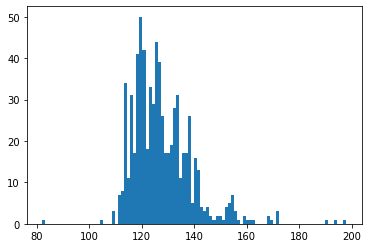

[['Q',
  'V',
  'Q',
  'L',
  'Q',
  'Q',
  'S',
  'G',
  'A',
  'E',
  'L',
  'V',
  'K',
  'P',
  'G',
  'A',
  'S',
  'V',
  'R',
  'M',
  'S',
  'C',
  'K',
  'A',
  'S',
  'G',
  'Y',
  'T',
  'F',
  'T',
  'N',
  'Y',
  'N',
  'M',
  'Y',
  'W',
  'V',
  'K',
  'Q',
  'S',
  'P',
  'G',
  'Q',
  'G',
  'L',
  'E',
  'W',
  'I',
  'G',
  'I',
  'F',
  'Y',
  'P',
  'G',
  'N',
  'G',
  'D',
  'T',
  'S',
  'Y',
  'N',
  'Q',
  'K',
  'F',
  'K',
  'D',
  'K',
  'A',
  'T',
  'L',
  'T',
  'A',
  'D',
  'K',
  'S',
  'S',
  'N',
  'T',
  'A',
  'Y',
  'M',
  'Q',
  'L',
  'S',
  'S',
  'L',
  'T',
  'S',
  'E',
  'D',
  'S',
  'A',
  'V',
  'Y',
  'Y',
  'C',
  'A',
  'R',
  'S',
  'G',
  'G',
  'S',
  'Y',
  'R',
  'Y',
  'D',
  'G',
  'G',
  'F',
  'D',
  'Y',
  'W',
  'G',
  'Q',
  'G',
  'T',
  'T',
  'V',
  'T',
  'V'],
 ['Q',
  'V',
  'Q',
  'L',
  'Q',
  'E',
  'S',
  'G',
  'P',
  'G',
  'L',
  'V',
  'A',
  'P',
  'S',
  'Q',
  'S',
  'L',
  'S',
  'I',
  'T',
  'C',
  'T'

In [10]:
sequences = []
seq_to_pdb = {}
count = 0
with open('data/all_heavy.fasta') as infile:

        for header, sequence, pdb in get_sequence(infile):
            #if count < 500:
            sequences.append(list(sequence))
                #count += 1
            
            seq_to_pdb[sequence] = pdb
            
sequences = [seq for seq in sequences if len(seq) < 200]

import matplotlib.pyplot as plt
lengths = [len(seq) for seq in sequences]

mode = max(set(lengths), key=lengths.count)

print(mode)

plt.hist(lengths, bins=100)
plt.show()


In [9]:
from torch.utils import data
from random import shuffle


class Dataset(data.Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        # Return the size of the dataset
        return len(self.targets)

    def __getitem__(self, index):
        # Retrieve inputs and targets at the given index
        X = self.inputs[index]
        y = self.targets[index]

        return X, y

def create_datasets(sequences, dataset_class, p_train=0.8, p_val=0.1, p_test=0.1):
    
    
    # Define partition sizes
    num_train = int(len(sequences)*p_train)
    num_val = int(len(sequences)*p_val)
    num_test = int(len(sequences)*p_test)

    # Split sequences into partitions
    sequences_train = sequences[:num_train-1]
    # add reversed sequences for training and shuffle
    sequences_train += [seq[::-1] for seq in sequences_train]
    shuffle(sequences_train)

    sequences_val = sequences[num_train:num_train+num_val-1]
    sequences_test = sequences[-num_test:-1]

    input_train = [['<sos>'] + list(seq)+['<eos>'] for seq in sequences_train]
    input_val = [['<sos>'] + list(seq)+['<eos>'] for seq in sequences_val]
    input_test = [['<sos>'] + list(seq)+['<eos>'] for seq in sequences_test]

    return (input_train, input_val, input_test)

(input_train, input_val, input_test) = create_datasets(sequences, Dataset)

TypeError: 'NoneType' object is not iterable

In [24]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    

class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        
        from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
        
        self.model_type = 'Transformer'
        
        self.pos_encoder = PositionalEncoding(ninp, dropout)

        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        
        self.t_encoder = TransformerEncoder(encoder_layers, nlayers)
        
        self.embed = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        
        decoder_layers = TransformerDecoderLayer(ninp, nhead, nhid, dropout)
        
        self.t_decoder = TransformerDecoder(decoder_layers, nlayers)


        self.ff = nn.Linear(ninp, ntoken)
        
        self._init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float(-1e-10)).masked_fill(mask == 1, float(0.0))
        
        return mask

 
    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
       

    def forward(self, src, src_mask, tgt, tgt_mask, src_pad_mask, tgt_pad_mask, mem_pad_mask=None):
        

        embeds = self.embed(src) * math.sqrt(self.ninp)
        
        positions = self.pos_encoder(embeds)
    
        
        encoded = self.t_encoder(positions)
        #encoded = self.t_encoder(positions, src_key_padding_mask=src_pad_mask)
        
        
        if mem_pad_mask is None:
            mem_pad_mask = tgt_pad_mask.clone()
            
        embeds = self.embed(tgt)
        positions = self.pos_encoder(embeds)
        #decoded = self.t_decoder(tgt=positions, memory=encoded, tgt_mask=tgt_mask,
        #                         tgt_key_padding_mask=tgt_pad_mask,
        #                         memory_key_padding_mask=mem_pad_mask)
        
        decoded = self.t_decoder(tgt=positions, memory=encoded, tgt_mask=tgt_mask)
  
        output = self.ff(decoded)

        return output




In [30]:
    
vocab = ['<pad>', "<sos>", "<eos>"] + ["A","C","D","E","F","G","H","I","K","L","M","N","P","Q","R","S","T","V","W","X","Y"]
char_nums = {token:vocab.index(token) for token in vocab}

def batchify(data):
    
    # get the length of each seq in your batch
    seq_lengths = torch.LongTensor([len(seq) for seq in data])

    train_vectorized = [[char_nums[char] for char in seq] for seq in data]
    
    sources = [seq[:-1] for seq in train_vectorized]
    targets = [seq[1:] for seq in train_vectorized]
    
    # dump padding everywhere, and place seqs on the left.
    # NOTE: you only need a tensor as big as your longest sequence
    src_tensor = torch.zeros((len(train_vectorized), seq_lengths.max()-1)).long()
    tgt_tensor = torch.zeros((len(train_vectorized), seq_lengths.max()-1)).long()

    
    for idx, (seq, seqlen) in enumerate(zip(sources, seq_lengths)):
        src_tensor[idx, :(seqlen-1)] = torch.LongTensor(seq)
    
    for idx, (seq, seqlen) in enumerate(zip(targets, seq_lengths)):
        tgt_tensor[idx, :(seqlen-1)] = torch.LongTensor(seq)
        
        
    # SORT YOUR TENSORS BY LENGTH!
    seq_lengths, perm_idx = seq_lengths.sort(0, descending=True)
    
    src_tensor = src_tensor[perm_idx]
    tgt_tensor = tgt_tensor[perm_idx]

    return src_tensor, tgt_tensor


(train_src, train_tgt) = batchify(input_train)
(val_src, val_tgt) = batchify(input_train)
(test_src, test_tgt) = batchify(input_train)


In [31]:
bptt = 60
max_len = max(map(len, sequences))
def get_batch(sources, targets, i):
    n_seqs = min(bptt, len(sources) - 1 - i)
    
    src = torch.cat([sources[i] for i in range(n_seqs)]).view(n_seqs,max_len+1)
        
    target = torch.cat([targets[i] for i in range(n_seqs)]).view(n_seqs,max_len+1)#.reshape(-1)
    
    return src, target



In [32]:
ntokens = len(vocab) # the size of vocabulary
emsize = 800 # embedding dimension
nhid = 400 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 4 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 4 # the number of heads in the multiheadattention models
dropout = 0.5 # the dropout value

In [33]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#  ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0)

lr = 4.0 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
#optimizer  = torch.optim.Adam(lr=lr, params=model.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

train_losses = []
val_losses = []
model.to(device)
import sys
import time
def train():
    
    train_loss = 0
    
    n_batches = 0
    
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()
    ntokens = len(vocab)
    src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    
    for batch, i in enumerate(range(0, train_src.size(0) - 1, bptt)):
        
        data, targets = get_batch(train_src, train_tgt, i)
    
        data, targets = data.to(device), targets.to(device)
        
        optimizer.zero_grad()
        
            
        src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
        src_pad_mask = (data == 0).bool().view(data.size(1), data.size(0))
        
        tgt_mask = model.generate_square_subsequent_mask(targets.size(0)).to(device)
        tgt_pad_mask = (targets == 0).bool().view(targets.size(1), targets.size(0))
        
        output = model(data, src_mask, targets, tgt_mask, src_pad_mask, tgt_pad_mask)
     
        output_trans = output.view(-1, ntokens)
        target_trans = targets.view(-1, targets.size(1) * targets.size(0)).squeeze(0)
        
        loss = criterion(output_trans, target_trans)
        
        n_batches += 1
        train_loss += loss
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        
        # Soft, hard accuracy
        #o = list(output.view(-1, ntokens)[0])
        #t = targets
        #print(o,t)
        #hard_acc = sum([i for i in range(len(targets)) if o[i] == t[i]])/len(targets)
        
        optimizer.step()
        
        total_loss += loss.item()
        log_interval = 1
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}|'.format(
                    epoch, batch, len(train_src) // bptt, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()
    
    train_losses.append(train_loss/n_batches)

def evaluate(eval_model, src, tgt):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    
    src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    
    with torch.no_grad():
        for i in range(0, src.size(0) - 1, bptt):
            data, targets = get_batch(src, tgt, i)
            data, targets = data.to(device), targets.to(device)
            
            src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
            src_pad_mask = (data == 0).bool().view(data.size(1), data.size(0))
        
            tgt_mask = model.generate_square_subsequent_mask(targets.size(0)).to(device)
            tgt_pad_mask = (targets == 0).bool().view(targets.size(1), targets.size(0))    
            
            output = eval_model(data, src_mask, targets, tgt_mask, src_pad_mask, tgt_pad_mask)
            
            output_trans = output.view(-1, ntokens)
            target_trans = targets.view(-1, targets.size(1) * targets.size(0)).squeeze(0)
            
            total_loss += len(data) * criterion(output_trans, target_trans).item()
            
    return total_loss / (len(src) - 1)


In [34]:
best_val_loss = float("inf")
epochs = 3 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train()
    val_loss = evaluate(model, val_src, val_tgt)
    val_losses.append(val_loss)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
          'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

    scheduler.step()

| epoch   1 |     1/    9 batches | lr 4.00 | ms/batch 75800.71 | loss 11.73 | ppl 124733.76|
| epoch   1 |     2/    9 batches | lr 4.00 | ms/batch 38958.12 | loss  8.75 | ppl  6279.66|
| epoch   1 |     3/    9 batches | lr 4.00 | ms/batch 39878.73 | loss  7.86 | ppl  2585.06|
| epoch   1 |     4/    9 batches | lr 4.00 | ms/batch 37974.11 | loss  7.68 | ppl  2155.34|
| epoch   1 |     5/    9 batches | lr 4.00 | ms/batch 37624.82 | loss 14.67 | ppl 2360867.20|
| epoch   1 |     6/    9 batches | lr 4.00 | ms/batch 37713.76 | loss 12.46 | ppl 258877.53|
| epoch   1 |     7/    9 batches | lr 4.00 | ms/batch 38069.89 | loss 10.48 | ppl 35573.52|
| epoch   1 |     8/    9 batches | lr 4.00 | ms/batch 38521.61 | loss  8.77 | ppl  6456.29|
| epoch   1 |     9/    9 batches | lr 4.00 | ms/batch 13421.02 | loss  8.92 | ppl  7512.49|
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 469.26s | valid loss 18.88 | valid ppl 158

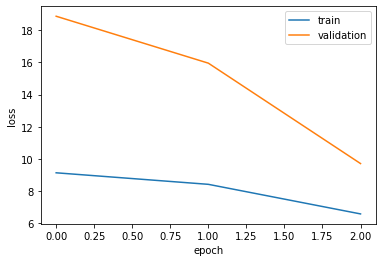

In [35]:

plt.figure()

plt.plot(train_losses, label="train")
plt.plot(val_losses, label="validation")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()


In [39]:
print(val_losses[-1])
test_loss

9.707452886045191


9.707452886045191

In [37]:
test_loss = evaluate(best_model, test_src, test_tgt)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)


KeyboardInterrupt: 

In [18]:
idx_to_letter = {val:key for key, val in char_nums.items()}

def sample_categorical(lnprobs, temperature=1.0):
    """
    Sample an element from a categorical distribution
    :param lnprobs: Outcome log-probabilities
    :param temperature: Sampling temperature. 1.0 follows the given distribution,
        0.0 returns the maximum probability element.
    :return: The index of the sampled element.
    """

    if temperature == 0.0:
        return lnprobs.argmax()
    p = F.softmax(lnprobs / temperature, dim=1)

    #print("softmaxed probs:", p)
    
    return dist.Categorical(p).sample()

def sample_sentence(model, query, max_len = 140, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    while len(query) < max_len and '<eos>' not in query:
        query_tensor, seq_lengths = batchify([query])
        query_tensor = query_tensor.to(device)
    
        src_mask = model.generate_square_subsequent_mask(len(query_tensor)).to(device)
        
        output = model(query_tensor, src_mask, torch.Tensor([len(query)])).view(-1, ntokens)
        
        next_char_idx = sample_categorical(output, temperature) #0.5
                
        try:
            query += [idx_to_letter[int(next_char_idx[-1])]]
        except IndexError:
            query += [idx_to_letter[int(next_char_idx)]]
            
    return query


In [19]:
import torch.distributions as dist
ntokens = len(vocab)

for _ in range(10):
    sample = sample_sentence(model, ["<sos>","E"], max_len = 500, temperature=0.9)

    print(len(sample), " ".join(sample))
    

60 <sos> E P T F S S S G G T A S L V Y G L V T K G G S S G T W M M Y T A M N D Q M Y T C T A S S G G L V P D T P V T P A A K <eos>
119 <sos> E V L V T T V T G Y F T Y G L V T V D T V T V T V L V T V T V T A R D T L K K G L V T T S S G L V S N S S G Q M M Y A R Q G L Q M S S L Q T V S S G T S G S A K L V T Y F A V A M Y W V T S S S G V S G T A S Y F A G T L V G E W L V K K <eos>
500 <sos> E G Y W G T S S G G L V T T A V K R Q M Y Y Y F P G V K N E P V T V T Y W Q M Y Y F P S G D K N N S S E P V T V K I E W T F T V T S L V T V T Q M G G G Y Y G L V T L V S Q K G G L Q M Y F T F T V S T S G V T A G L V T Y P G L V T S G S G T W Y T A K G R Q K G G R D T S V N S S L V A K S G V T S T S L Q M Y F L V T Y T V T Y W V T S G G L V T V T H T W V Q M Y W V T P S G Q M N T V T T P S D N L Q T P S G T V F T V K G Q M S L V T T S Y F P G G G S G Y F T T T T P V T L V T L V T V S L V T A V T V H I L Q M Y F S S G S S T V R D T P P G Y W L V T V T L Q P V T N S V T S L V L Q M G T A R D T F T S G G I